# ML for Insider Trading Detection in a Toy Limit Order Book

In this notebook we build an end-to-end miniature surveillance pipeline:

1. **Simulate a limit order book (LOB)** for a single asset with several agent types:
   - Noise traders
   - Market makers
   - Prop traders
   - Different kinds of illegal insiders and manipulators

2. **Generate synthetic trade data** under many market “scenarios”.

3. **Extract features** at two levels:
   - Per agent (e.g. volume, positions, P&L)
   - Per time window (e.g. volatility, volume, presence of illegal traders)

4. **Train a machine-learning model** to detect suspicious agents based on their trading behaviour.

5. **Interpret the model** and discuss what it actually learned, including some common pitfalls.

This is not a realistic surveillance system. The goal is to create a **controlled sandbox** where we can see how insider-like behaviour leaves a statistical footprint and how an ML model can pick it up.

In [1]:
import random
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
random.seed(42)
np.random.seed(42)

## Core limit order book structures

We start with the **order book**, the matching engine of our simulated market.

Concepts:

- **Order** – a request to buy or sell a quantity at a given price (or “at market”).
- **Order book** – two sorted lists:
  - **Bids**: buy limit orders, sorted by highest price then earliest time.
  - **Asks**: sell limit orders, sorted by lowest price then earliest time.
- **Mid-price** – the average of best bid and best ask; falls back to the fundamental value when the book is empty.

Responsibilities of the `OrderBook` class:

- Maintain the bid/ask queues.
- Insert new limit orders in **price-time priority**.
- Match incoming orders against existing ones and produce **trades**.
- Provide helper methods like best bid/ask and mid-price.

This gives us a minimal but realistic microstructure to trade in.


In [2]:
@dataclass
class Order:
    id: int
    time: int
    agent_id: int
    side: str  # "BUY" or "SELL"
    price: Optional[float]  # None for market orders
    quantity: int
    is_market: bool = False


class OrderBook:
    def __init__(self):
        self.bids: List[Order] = []  # sorted by price desc, then time asc
        self.asks: List[Order] = []  # sorted by price asc, then time asc
        self.order_lookup: Dict[int, Order] = {}
        self.trades: List[Dict[str, Any]] = []

    # --- Best quotes and mid price ---

    def best_bid(self) -> Optional[Order]:
        return self.bids[0] if self.bids else None

    def best_ask(self) -> Optional[Order]:
        return self.asks[0] if self.asks else None

    def mid_price(self, fallback_price: float) -> float:
        """
        Mid-price based on best bid/ask; if book is empty, use fallback_price
        (usually the current fundamental value).
        """
        bid = self.best_bid()
        ask = self.best_ask()
        if bid is None and ask is None:
            return fallback_price
        if bid is None:
            return ask.price
        if ask is None:
            return bid.price
        return 0.5 * (bid.price + ask.price)

    # --- Order management helpers ---

    def cancel_agent_orders(self, agent_id: int):
        """Remove all resting orders belonging to a given agent."""
        self.bids = [o for o in self.bids if o.agent_id != agent_id]
        self.asks = [o for o in self.asks if o.agent_id != agent_id]
        to_delete = [oid for oid, o in self.order_lookup.items() if o.agent_id == agent_id]
        for oid in to_delete:
            del self.order_lookup[oid]

    def _add_limit_order_to_book(self, order: Order):
        book_side = self.bids if order.side == "BUY" else self.asks
        inserted = False

        for i, existing in enumerate(book_side):
            if order.side == "BUY":
                # Higher price first; for same price, earlier time first
                if (order.price > existing.price) or (
                        order.price == existing.price and order.time < existing.time
                ):
                    book_side.insert(i, order)
                    inserted = True
                    break
            else:  # SELL
                # Lower price first; for same price, earlier time first
                if (order.price < existing.price) or (
                        order.price == existing.price and order.time < existing.time
                ):
                    book_side.insert(i, order)
                    inserted = True
                    break

        if not inserted:
            book_side.append(order)

        self.order_lookup[order.id] = order

    # --- Core matching logic ---

    def process_order(self, order: Order) -> List[Dict[str, Any]]:
        """
        Match an incoming order against the book, then (if a limit order) add remainder.
        Returns list of trades generated.
        """
        trades: List[Dict[str, Any]] = []
        remaining_qty = order.quantity

        if order.side == "BUY":
            book_side = self.asks

            def crossing(best: Order) -> bool:
                if order.is_market:
                    return True
                return order.price is not None and order.price >= best.price

        else:  # SELL
            book_side = self.bids

            def crossing(best: Order) -> bool:
                if order.is_market:
                    return True
                return order.price is not None and order.price <= best.price

        # Match against opposite side
        while remaining_qty > 0 and book_side:
            best = book_side[0]
            if not crossing(best):
                break

            trade_qty = min(remaining_qty, best.quantity)
            trade_price = best.price  # price of resting order
            remaining_qty -= trade_qty
            best.quantity -= trade_qty

            # Record trade participants
            if order.side == "BUY":
                buy_id = order.agent_id
                sell_id = best.agent_id
            else:
                buy_id = best.agent_id
                sell_id = order.agent_id

            trade = {
                "time": order.time,
                "price": trade_price,
                "quantity": trade_qty,
                "buy_agent": buy_id,
                "sell_agent": sell_id,
            }
            trades.append(trade)
            self.trades.append(trade)

            # Remove fully filled resting order
            if best.quantity == 0:
                self.order_lookup.pop(best.id, None)
                book_side.pop(0)

        # If it's a limit order and there is remaining quantity, add to book
        if (not order.is_market) and remaining_qty > 0:
            order.quantity = remaining_qty
            self._add_limit_order_to_book(order)

        return trades



## Agents and the common interface

Every trader in our simulation is an **agent**:

- Each agent has **cash** and **position**.
- On each time step, the agent is asked to propose **orders** (`step`).
- When a trade happens, the agent’s `on_trade` method is called to update P&L.

We also attach **labels** for later ML tasks:

- `label_is_illegal`: whether this agent is an insider/manipulator.
- `label_illegal_type`: what kind of illegal strategy it uses (event insider, pump-and-dump, etc.).
- `group_id`: used for rings of coordinated accounts.

All concrete agent types inherit from this base class and implement their own `step` behaviour.


In [32]:
class Agent:
    """
    Base class for all agents.
    """

    def __init__(self, agent_id: int, agent_type: str):
        self.id = agent_id
        self.type = agent_type  # e.g. "NOISE", "MM", "PROP", "INSIDER"
        self.cash = 0.0
        self.position = 0
        self.trade_history: List[Dict[str, Any]] = []

        # Labels for detection tasks
        self.label_is_illegal: bool = False
        self.label_illegal_type: Optional[str] = None  # e.g. "event_insider", "pump"
        self.group_id: Optional[int] = None  # for rings / groups

    def step(
            self,
            t: int,
            book: OrderBook,
            fundamental: float,
            mid_price: float,
    ) -> List[Dict[str, Any]]:
        """
        Return a list of order requests (dicts) for this time step.
        Base class: does nothing.
        """
        return []

    def on_trade(self, price: float, quantity: int, side: str):
        """
        Update cash/position when this agent is involved in a trade.
        side is "BUY" or "SELL" from this agent's perspective.
        """
        if side == "BUY":
            self.position += quantity
            self.cash -= price * quantity
        else:  # SELL
            self.position -= quantity
            self.cash += price * quantity

        self.trade_history.append(
            {"price": price, "quantity": quantity, "side": side}
        )

### Noise traders

Noise traders model **uninformed, random flow**:

- With probability `p_trade` they place an order at each time step.
- They randomly choose **buy vs sell** (with a small optional bias).
- They randomly choose **market vs limit** orders.
- Limit orders are placed near the current mid-price with small noise.

Noise traders are important because they:

- Create background liquidity and randomness.
- Make the insiders harder to spot compared to a trivially empty market.


In [4]:
class NoiseTrader(Agent):
    def __init__(
            self,
            agent_id: int,
            p_trade: float = 0.2,
            p_market: float = 0.5,
            max_qty: int = 10,
            direction_bias: float = 0.0,  # >0 = slight buy bias, <0 = sell bias
    ):
        super().__init__(agent_id, agent_type="NOISE")
        self.p_trade = p_trade
        self.p_market = p_market
        self.max_qty = max_qty
        self.direction_bias = direction_bias

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        if random.random() > self.p_trade:
            return []

        # Direction: random with optional bias
        base = random.random() - 0.5 + self.direction_bias
        side = "BUY" if base >= 0 else "SELL"

        quantity = random.randint(1, self.max_qty)
        is_market = random.random() < self.p_market

        if is_market:
            price = None
        else:
            # Limit price around mid with small noise
            spread = 0.002  # 0.2%
            noise = np.random.normal(0, spread)
            if side == "BUY":
                price = mid_price * (1 - abs(noise))
            else:
                price = mid_price * (1 + abs(noise))
            price = round(float(price), 2)

        return [
            {
                "side": side,
                "quantity": quantity,
                "price": price,
                "is_market": is_market,
            }
        ]

### Market makers

Market makers continuously quote both **bid** and **ask** prices:

- They cancel their previous quotes every step and post new ones.
- Quotes are centered around the current mid-price with a given **spread**.
- They manage **inventory risk** by slightly skewing quotes when they get too long/short.
- They have a `max_inventory` to avoid extreme positions.

Market makers:

- Provide tight spreads and depth in the book.
- Trade a lot but aim for **inventory neutrality** and profit from the spread.
- Serve as a useful contrast to illegal directional traders.


In [5]:
class MarketMaker(Agent):
    def __init__(
            self,
            agent_id: int,
            spread: float = 0.002,  # half-spread (0.2%)
            size: int = 20,
            max_inventory: int = 200,
    ):
        super().__init__(agent_id, agent_type="MM")
        self.spread = spread
        self.size = size
        self.max_inventory = max_inventory

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        # Cancel all previous quotes for this MM
        book.cancel_agent_orders(self.id)

        # Adjust quotes slightly based on inventory
        inventory_skew = 0.001 * self.position  # more long -> higher ask, lower bid
        bid_price = mid_price * (1 - self.spread - inventory_skew)
        ask_price = mid_price * (1 + self.spread - inventory_skew)

        bid_price = round(float(bid_price), 2)
        ask_price = round(float(ask_price), 2)

        orders: List[Dict[str, Any]] = []

        if self.position < self.max_inventory:
            orders.append(
                {
                    "side": "BUY",
                    "quantity": self.size,
                    "price": bid_price,
                    "is_market": False,
                }
            )
        if self.position > -self.max_inventory:
            orders.append(
                {
                    "side": "SELL",
                    "quantity": self.size,
                    "price": ask_price,
                    "is_market": False,
                }
            )

        return orders

### Prop traders (legal speculative traders)

Prop traders are **legal speculators** who try to exploit short-term price patterns:

- They can be **momentum** traders (buy when price is rising, sell when falling).
- Or **mean-reversion** traders (do the opposite).
- They trade with probability `p_trade` when there has been a meaningful price move.

Why add them?

- They introduce **high-activity, directional but legal** behaviour.
- This prevents the model from equating “directional trading” with “illegal” too easily.


In [6]:
class PropTrader(Agent):
    def __init__(
            self,
            agent_id: int,
            mode: str = "momentum",  # or "mean_reversion"
            p_trade: float = 0.3,
            max_qty: int = 15,
    ):
        super().__init__(agent_id, agent_type="PROP")
        assert mode in ("momentum", "mean_reversion")
        self.mode = mode
        self.p_trade = p_trade
        self.max_qty = max_qty
        self.last_mid: Optional[float] = None

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        # Need at least one previous mid to infer a direction
        if self.last_mid is None:
            self.last_mid = mid_price
            return []

        if random.random() > self.p_trade:
            self.last_mid = mid_price
            return []

        price_change = mid_price - self.last_mid
        if abs(price_change) < 1e-6:
            self.last_mid = mid_price
            return []

        # Direction based on simple price change
        if self.mode == "momentum":
            side = "BUY" if price_change > 0 else "SELL"
        else:  # mean_reversion
            side = "SELL" if price_change > 0 else "BUY"

        quantity = random.randint(1, self.max_qty)
        is_market = random.random() < 0.6  # relatively aggressive

        if is_market:
            price = None
        else:
            # Limit just inside the spread
            if side == "BUY":
                price = mid_price * 0.999
            else:
                price = mid_price * 1.001
            price = round(float(price), 2)

        self.last_mid = mid_price

        return [
            {
                "side": side,
                "quantity": quantity,
                "price": price,
                "is_market": is_market,
            }
        ]

## Illegal strategies: insiders and manipulators

All illegal strategies share some common structure:

- They are marked with `label_is_illegal = True`.
- They know whether they are part of a **group/ring** (`group_id`).
- Some of them are tied to a **fundamental event** (e.g. earnings surprise), with known:
  - `event_time`
  - `direction` (+1 for good news / price up, -1 for bad news / price down)

The `InsiderBase` class captures this shared information. Each concrete strategy only needs to implement its own `step` logic.


In [7]:
class InsiderBase(Agent):
    """
    Base class for all illegal informational or manipulative strategies.
    """

    def __init__(
            self,
            agent_id: int,
            scenario_name: str,
            group_id: Optional[int] = None,
            event_time: Optional[int] = None,
            direction: int = 1,
    ):
        super().__init__(agent_id, agent_type="INSIDER")
        self.label_is_illegal = True
        self.label_illegal_type = scenario_name
        self.group_id = group_id
        self.event_time = event_time
        self.direction = direction  # +1 up, -1 down

    # step() is implemented by subclasses

### Event and slow insiders

We first define two **informational insiders** that trade around a known event:

1. `EventInsider`
   - Starts trading a bit before the event.
   - Builds a directional position (long if good news, short if bad).
   - Then unwinds over a fixed horizon after the event.

2. `SlowInsider`
   - Starts much earlier than the event.
   - Trades smaller sizes with lower intensity.
   - Mostly uses limit orders, so their behaviour looks more “patient”.

In both cases, the key idea is:
> *“Trade in the direction of the coming fundamental jump, before the rest of the market knows.”*

In [8]:
class EventInsider(InsiderBase):
    """
    Classic short-horizon event insider:
    - builds a directional position before event_time
    - unwinds over a finite horizon after the event
    """

    def __init__(
            self,
            agent_id: int,
            event_time: int,
            direction: int = 1,
            start_time: Optional[int] = None,
            trade_size: int = 10,
            unwind_horizon: int = 80,
            group_id: Optional[int] = None,
    ):
        super().__init__(
            agent_id,
            scenario_name="event_insider",
            group_id=group_id,
            event_time=event_time,
            direction=direction,
        )
        self.trade_size = trade_size
        self.unwind_horizon = unwind_horizon
        self.start_time = start_time if start_time is not None else max(0, event_time - 50)

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if self.event_time is None:
            return orders

        # Before start: no trading
        if t < self.start_time:
            return orders

        # Accumulation phase: before event
        if self.start_time <= t < self.event_time:
            side = "BUY" if self.direction > 0 else "SELL"
            is_market = random.random() < 0.3
            if is_market:
                price = None
            else:
                # Be fairly aggressive near mid
                if side == "BUY":
                    price = mid_price * 1.001
                else:
                    price = mid_price * 0.999
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": self.trade_size,
                    "price": price,
                    "is_market": is_market,
                }
            )

        # Unwind phase
        elif self.event_time <= t < self.event_time + self.unwind_horizon:
            # If event up, likely long -> sell; if down, likely short -> buy back
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.trade_size, abs(self.position))
            else:
                return orders

            is_market = True  # be aggressive to exit
            price = None

            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders


class SlowInsider(InsiderBase):
    """
    Long-horizon insider:
    - starts much earlier before event
    - trades smaller size with lower intensity
    - mostly uses limit orders near the book
    """

    def __init__(
            self,
            agent_id: int,
            event_time: int,
            direction: int = 1,
            start_time: Optional[int] = None,
            max_trade_size: int = 6,
            p_trade_pre: float = 0.3,
            unwind_horizon: int = 120,
    ):
        super().__init__(
            agent_id,
            scenario_name="slow_insider",
            event_time=event_time,
            direction=direction,
        )
        self.max_trade_size = max_trade_size
        self.p_trade_pre = p_trade_pre
        self.unwind_horizon = unwind_horizon
        if start_time is None:
            self.start_time = max(0, event_time - 300)
        else:
            self.start_time = start_time

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if self.event_time is None:
            return orders

        if t < self.start_time:
            return orders

        if self.start_time <= t < self.event_time:
            if random.random() > self.p_trade_pre:
                return orders
            side = "BUY" if self.direction > 0 else "SELL"
            quantity = random.randint(1, self.max_trade_size)
            # Mostly limit orders; occasionally market
            is_market = random.random() < 0.1
            if is_market:
                price = None
            else:
                # Place near mid with small offset
                spread = 0.0015
                if side == "BUY":
                    price = mid_price * (1 - spread)
                else:
                    price = mid_price * (1 + spread)
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": quantity,
                    "price": price,
                    "is_market": is_market,
                }
            )

        elif self.event_time <= t < self.event_time + self.unwind_horizon:
            # Gradual unwind based on current position
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.max_trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.max_trade_size, abs(self.position))
            else:
                return orders

            is_market = random.random() < 0.5
            if is_market:
                price = None
            else:
                if side == "SELL":
                    price = mid_price * 0.999
                else:
                    price = mid_price * 1.001
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders

### Stealth insiders and pump-and-dump manipulators

We then add two more sophisticated / different types of bad actors:

1. `StealthInsider`
   - Trades in the informed direction *most* of the time.
   - Occasionally places **decoy trades** in the opposite direction.
   - Uses slightly different pricing for decoys to look less suspicious.

   Idea: make the order flow look less one-sided while still building a net position.

2. `PumpAndDumpManipulator`
   - Not based on fundamental information.
   - Starts at a chosen `start_time`.
   - **Pump phase**: aggressively buy (or sell) to push the price away.
   - **Dump phase**: exit the position and (ideally) lock in profits.

In [9]:
class StealthInsider(InsiderBase):
    """
    Stealth insider:
    - mixes informed trades with occasional "decoy" trades in opposite direction
    - moderate intensity and order splitting
    """

    def __init__(
            self,
            agent_id: int,
            event_time: int,
            direction: int = 1,
            start_time: Optional[int] = None,
            max_trade_size: int = 8,
            p_trade_pre: float = 0.4,
            decoy_prob: float = 0.15,
            unwind_horizon: int = 80,
    ):
        super().__init__(
            agent_id,
            scenario_name="stealth_insider",
            event_time=event_time,
            direction=direction,
        )
        self.max_trade_size = max_trade_size
        self.p_trade_pre = p_trade_pre
        self.decoy_prob = decoy_prob
        self.unwind_horizon = unwind_horizon
        if start_time is None:
            self.start_time = max(0, event_time - 120)
        else:
            self.start_time = start_time

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if self.event_time is None:
            return orders

        if t < self.start_time:
            return orders

        if self.start_time <= t < self.event_time:
            if random.random() > self.p_trade_pre:
                return orders

            informed_side = "BUY" if self.direction > 0 else "SELL"
            is_decoy = random.random() < self.decoy_prob
            side = "SELL" if (informed_side == "BUY" and is_decoy) else "BUY" if (
                        informed_side == "SELL" and is_decoy) else informed_side

            quantity = random.randint(1, self.max_trade_size)
            is_market = random.random() < 0.4

            if is_market:
                price = None
            else:
                # Limit orders around mid; decoys can be slightly further away
                offset = 0.001 if not is_decoy else 0.002
                if side == "BUY":
                    price = mid_price * (1 - offset)
                else:
                    price = mid_price * (1 + offset)
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": quantity,
                    "price": price,
                    "is_market": is_market,
                }
            )

        elif self.event_time <= t < self.event_time + self.unwind_horizon:
            # Similar unwind to EventInsider
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.max_trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.max_trade_size, abs(self.position))
            else:
                return orders

            is_market = True
            price = None
            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders


class PumpAndDumpManipulator(InsiderBase):
    """
    Pump-and-dump style manipulator:
    - no fundamental jump required
    - aggressively pushes price in one direction (pump)
    - then exits (dump)
    """

    def __init__(
            self,
            agent_id: int,
            start_time: int,
            direction: int = 1,  # +1 pump up, -1 pump down
            pump_horizon: int = 80,
            unwind_horizon: int = 80,
            trade_size: int = 12,
            group_id: Optional[int] = None,
    ):
        super().__init__(
            agent_id,
            scenario_name="pump_and_dump",
            group_id=group_id,
            event_time=None,
            direction=direction,
        )
        self.start_time = start_time
        self.pump_horizon = pump_horizon
        self.unwind_horizon = unwind_horizon
        self.trade_size = trade_size

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if t < self.start_time:
            return orders

        # Pump phase
        if self.start_time <= t < self.start_time + self.pump_horizon:
            side = "BUY" if self.direction > 0 else "SELL"
            quantity = self.trade_size
            is_market = random.random() < 0.7  # very aggressive
            if is_market:
                price = None
            else:
                if side == "BUY":
                    price = mid_price * 1.002
                else:
                    price = mid_price * 0.998
                price = round(float(price), 2)
            orders.append(
                {
                    "side": side,
                    "quantity": quantity,
                    "price": price,
                    "is_market": is_market,
                }
            )

        # Dump phase
        elif self.start_time + self.pump_horizon <= t < self.start_time + self.pump_horizon + self.unwind_horizon:
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.trade_size, abs(self.position))
            else:
                return orders

            is_market = True
            price = None
            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders

## Simulation configuration and scenario sampler

Rather than manually specifying one market scenario, we define:

- `SimulationConfig`: describes one run of the world:
  - Length `T`
  - Whether there is a **fundamental event** (jump in true value)
  - Event time and jump size/direction
  - Numbers of noise traders, market makers, prop traders
  - A list of `InsiderSpec` entries describing illegal agents (if any)

- `InsiderSpec`: simple structure describing what kind of illegal agent to create (strategy, group id, etc.).

The helper `sample_random_config(run_id)` randomly creates a realistic-ish scenario:

- Some runs have a fundamental event, some do not.
- Events can be up or down, early or late.
- Some runs have insiders; some have none (clean markets).
- Occasionally we add pump-and-dump manipulators instead of event insiders.

By sampling many such configs we can generate a **diverse training dataset**.


In [10]:
@dataclass
class InsiderSpec:
    """
    Configuration for a single illegal agent in a scenario.
    """
    strategy: str  # "event", "slow", "stealth", "ring", "pump"
    start_time: Optional[int] = None
    trade_size: Optional[int] = None
    group_id: Optional[int] = None


@dataclass
class SimulationConfig:
    run_id: int
    T: int = 1000
    has_event: bool = True
    event_time: Optional[int] = None
    jump_size: float = 0.1  # absolute size, sign from jump_direction
    jump_direction: int = 1  # +1 or -1
    volatility: float = 0.05  # std of fundamental random walk
    n_noise_traders: int = 20
    n_market_makers: int = 1
    n_prop_traders: int = 0
    insider_specs: List[InsiderSpec] = field(default_factory=list)


def sample_random_config(run_id: int) -> SimulationConfig:
    """
    Sample a random scenario config, including:
    - presence/absence of an event
    - number/type of insiders (possibly none)
    - background trader composition
    """
    T = random.randint(800, 1500)

    has_event = random.random() < 0.7  # 70% of runs have a fundamental event
    if has_event:
        event_time = random.randint(int(0.3 * T), int(0.8 * T))
        jump_size = random.uniform(0.05, 0.2)  # 5% to 20%
        jump_direction = random.choice([-1, 1])
    else:
        event_time = None
        jump_size = 0.0
        jump_direction = 0

    n_noise_traders = random.randint(10, 40)
    n_market_makers = random.choice([1, 2])
    n_prop_traders = random.choice([0, 1, 2])

    insider_specs: List[InsiderSpec] = []

    if has_event:
        # Some runs with event but no insider at all
        if random.random() < 0.7:
            n_insiders = random.randint(1, 3)
            # With some probability use a ring of insiders
            if random.random() < 0.4 and n_insiders >= 2:
                group_id = random.randint(1, 10_000)
                for _ in range(n_insiders):
                    insider_specs.append(
                        InsiderSpec(strategy="ring", group_id=group_id)
                    )
            else:
                for _ in range(n_insiders):
                    strategy = random.choice(["event", "slow", "stealth"])
                    insider_specs.append(InsiderSpec(strategy=strategy))
    else:
        # No fundamental event: maybe add pump-and-dump manipulators
        if random.random() < 0.3:
            n_illegal = random.randint(1, 2)
            group_id = random.randint(1, 10_000) if n_illegal > 1 else None
            for _ in range(n_illegal):
                insider_specs.append(
                    InsiderSpec(strategy="pump", group_id=group_id)
                )

    config = SimulationConfig(
        run_id=run_id,
        T=T,
        has_event=has_event,
        event_time=event_time,
        jump_size=jump_size,
        jump_direction=jump_direction,
        volatility=0.05,
        n_noise_traders=n_noise_traders,
        n_market_makers=n_market_makers,
        n_prop_traders=n_prop_traders,
        insider_specs=insider_specs,
    )
    return config

## Simulation core: running a market scenario

`run_simulation(config)` takes a `SimulationConfig` and simulates **one world**:

1. Initialise:
   - Fundamental value (hidden true price) `v`.
   - Empty `OrderBook`.
   - All agents (market makers, prop traders, noise traders, insiders/manipulators).

2. For each time step `t`:
   - Update the **fundamental value**:
     - Random walk most of the time.
     - Optional jump at `event_time`.
   - Compute current **mid-price** from the book.
   - Ask each agent for orders via `agent.step(...)`.
   - Feed orders into the `OrderBook`, generating trades.
   - Update agents’ **cash and positions** when trades occur.
   - Record the new mid-price.

3. At the end, return:
   - The `config` (for labels).
   - Time series of `fundamental_values` and `mid_prices`.
   - The final `OrderBook`.
   - The list of all `agents`.
   - A `trades_df` DataFrame with all executed trades.

This function is the **engine** that produces synthetic market data for one scenario.


In [11]:
def run_simulation(config: SimulationConfig) -> Dict[str, Any]:
    """
    Run a single simulation according to the given config.
    Returns:
        {
            "config": config,
            "fundamental_values": np.ndarray,
            "mid_prices": np.ndarray,
            "book": OrderBook,
            "agents": List[Agent],
            "trades_df": pd.DataFrame,
        }
    """
    T = config.T

    # World state
    fundamental_values: List[float] = []
    mid_prices: List[float] = []
    v = 100.0  # initial fundamental value

    book = OrderBook()
    agents: List[Agent] = []
    next_agent_id = 1

    # --- Create market makers ---
    for _ in range(config.n_market_makers):
        spread = random.uniform(0.0015, 0.003)
        size = random.randint(10, 30)
        max_inv = random.randint(150, 300)
        mm = MarketMaker(
            agent_id=next_agent_id,
            spread=spread,
            size=size,
            max_inventory=max_inv,
        )
        agents.append(mm)
        next_agent_id += 1

    # --- Create prop traders ---
    for _ in range(config.n_prop_traders):
        mode = random.choice(["momentum", "mean_reversion"])
        p_trade = random.uniform(0.2, 0.4)
        max_qty = random.randint(5, 20)
        pt = PropTrader(
            agent_id=next_agent_id,
            mode=mode,
            p_trade=p_trade,
            max_qty=max_qty,
        )
        agents.append(pt)
        next_agent_id += 1

    # --- Create noise traders (heterogeneous) ---
    for _ in range(config.n_noise_traders):
        p_trade = random.uniform(0.1, 0.4)
        p_market = random.uniform(0.2, 0.8)
        max_qty = random.randint(5, 20)
        direction_bias = random.uniform(-0.1, 0.1)  # small
        nt = NoiseTrader(
            agent_id=next_agent_id,
            p_trade=p_trade,
            p_market=p_market,
            max_qty=max_qty,
            direction_bias=direction_bias,
        )
        agents.append(nt)
        next_agent_id += 1

    # --- Create insiders / manipulators based on insider_specs ---
    for spec in config.insider_specs:
        strat = spec.strategy
        group_id = spec.group_id

        if strat in ("event", "ring", "slow", "stealth"):
            # These all rely on the fundamental event
            if not config.has_event or config.event_time is None or config.jump_direction == 0:
                continue  # inconsistent config, skip

            event_time = config.event_time
            direction = config.jump_direction

            if strat == "event" or strat == "ring":
                start_time = event_time - random.randint(40, 100)
                trade_size = spec.trade_size if spec.trade_size is not None else random.randint(6, 12)
                unwind_horizon = random.randint(60, 120)
                insider = EventInsider(
                    agent_id=next_agent_id,
                    event_time=event_time,
                    direction=direction,
                    start_time=start_time,
                    trade_size=trade_size,
                    unwind_horizon=unwind_horizon,
                    group_id=group_id,
                )
            elif strat == "slow":
                start_time = event_time - random.randint(150, 350)
                max_trade_size = spec.trade_size if spec.trade_size is not None else random.randint(3, 7)
                p_trade_pre = random.uniform(0.2, 0.4)
                unwind_horizon = random.randint(100, 160)
                insider = SlowInsider(
                    agent_id=next_agent_id,
                    event_time=event_time,
                    direction=direction,
                    start_time=start_time,
                    max_trade_size=max_trade_size,
                    p_trade_pre=p_trade_pre,
                    unwind_horizon=unwind_horizon,
                )
            else:  # stealth
                start_time = event_time - random.randint(80, 160)
                max_trade_size = spec.trade_size if spec.trade_size is not None else random.randint(4, 10)
                p_trade_pre = random.uniform(0.3, 0.5)
                decoy_prob = random.uniform(0.1, 0.25)
                unwind_horizon = random.randint(60, 120)
                insider = StealthInsider(
                    agent_id=next_agent_id,
                    event_time=event_time,
                    direction=direction,
                    start_time=start_time,
                    max_trade_size=max_trade_size,
                    p_trade_pre=p_trade_pre,
                    decoy_prob=decoy_prob,
                    unwind_horizon=unwind_horizon,
                )

        elif strat == "pump":
            # Pump-and-dump manipulator, no fundamental event required
            start_time = spec.start_time
            if start_time is None:
                start_time = random.randint(int(0.2 * T), int(0.6 * T))
            direction = random.choice([1, -1])
            pump_horizon = random.randint(40, 100)
            unwind_horizon = random.randint(40, 120)
            trade_size = spec.trade_size if spec.trade_size is not None else random.randint(8, 15)
            insider = PumpAndDumpManipulator(
                agent_id=next_agent_id,
                start_time=start_time,
                direction=direction,
                pump_horizon=pump_horizon,
                unwind_horizon=unwind_horizon,
                trade_size=trade_size,
                group_id=group_id,
            )
        else:
            continue  # unknown strategy

        agents.append(insider)
        next_agent_id += 1

    agents_by_id: Dict[int, Agent] = {a.id: a for a in agents}

    order_id_counter = 1

    # --- Main time loop ---
    for t in range(T):
        # Fundamental value process
        if (
                config.has_event
                and config.event_time is not None
                and config.jump_direction != 0
                and t == config.event_time
        ):
            v *= (1 + config.jump_direction * abs(config.jump_size))
        else:
            v += np.random.normal(0, config.volatility)

        fundamental_values.append(v)

        # Use current book state to get a mid-price before orders
        mid_before = book.mid_price(v)

        # Each agent submits orders
        for agent in agents:
            order_requests = agent.step(t, book, v, mid_before)
            for req in order_requests:
                order = Order(
                    id=order_id_counter,
                    time=t,
                    agent_id=agent.id,
                    side=req["side"],
                    price=req["price"],
                    quantity=req["quantity"],
                    is_market=req["is_market"],
                )
                order_id_counter += 1

                trades = book.process_order(order)
                # Update agent P&L for each trade
                for tr in trades:
                    buy_agent = agents_by_id[tr["buy_agent"]]
                    sell_agent = agents_by_id[tr["sell_agent"]]
                    qty = tr["quantity"]
                    price = tr["price"]
                    buy_agent.on_trade(price, qty, "BUY")
                    sell_agent.on_trade(price, qty, "SELL")

        mid_after = book.mid_price(v)
        mid_prices.append(mid_after)

    # Convert trades to DataFrame
    trades_df = pd.DataFrame(book.trades)

    results = {
        "config": config,
        "fundamental_values": np.array(fundamental_values),
        "mid_prices": np.array(mid_prices),
        "book": book,
        "agents": agents,
        "trades_df": trades_df,
    }
    return results

## Inspecting a single simulation

Before jumping into machine learning, it’s useful to **see** what one simulated world looks like:

- Plot the **fundamental value** vs. **mid-price** over time.
  - We can visually inspect how prices follow the true value and react to jumps.
- Print a few **trades** to see the structure of `trades_df`.
- Build an **agent P&L summary** to see who made money and how much.

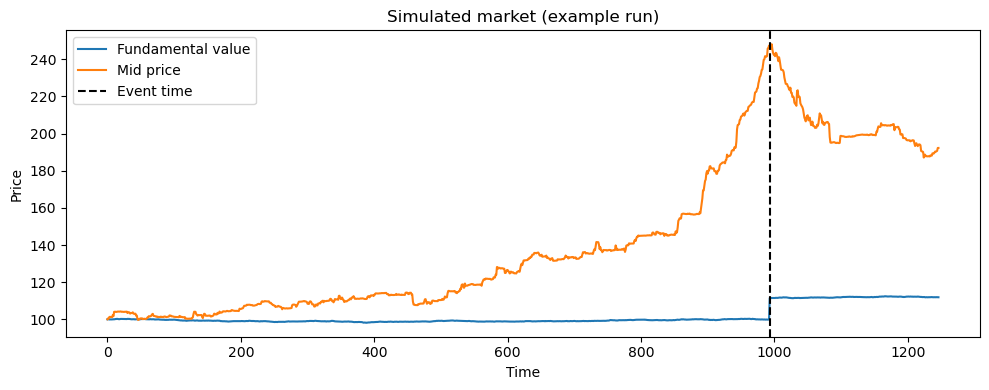

In [33]:
# Example usage:
config_example = sample_random_config(run_id=0)
results_example = run_simulation(config_example)

fundamental_values = results_example["fundamental_values"]
mid_prices = results_example["mid_prices"]
event_time = config_example.event_time

plt.figure(figsize=(10, 4))
plt.plot(fundamental_values, label="Fundamental value")
plt.plot(mid_prices, label="Mid price")
if config_example.has_event and event_time is not None:
    plt.axvline(event_time, color="k", linestyle="--", label="Event time")
plt.title("Simulated market (example run)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
trades_df_example = results_example["trades_df"]
print("First few trades:")
trades_df_example.head()

First few trades:


,time,price,quantity,buy_agent,sell_agent
0,0,100.25,9,10,1
1,0,99.91,5,2,17
2,0,100.00,4,38,35
3,0,100.00,1,39,35
4,0,100.16,4,39,37


In [36]:
# P&L summary
last_mid = mid_prices[-1]
agents_example = results_example["agents"]
summary_rows = []
for a in agents_example:
    equity = a.cash + a.position * last_mid
    summary_rows.append(
        {
            "agent_id": a.id,
            "type": a.type,
            "label_is_illegal": a.label_is_illegal,
            "label_illegal_type": a.label_illegal_type,
            "group_id": a.group_id,
            "cash": round(a.cash, 2),
            "position": a.position,
            "equity": round(equity, 2),
        }
    )
summary_df_example = pd.DataFrame(summary_rows).sort_values("equity", ascending=False)
print("Agent P&L summary (example run):")
summary_df_example

Agent P&L summary (example run):


,agent_id,type,label_is_illegal,label_illegal_type,group_id,cash,position,equity
16,17,NOISE,False,None,NaN,-57352.45,441,27445.23
4,5,NOISE,False,None,NaN,-66075.20,466,23529.61
38,39,NOISE,False,None,NaN,-61845.16,412,17376.26
32,33,NOISE,False,None,NaN,-22815.10,204,16411.04
11,12,NOISE,False,None,NaN,-21545.77,195,15949.80
34,35,NOISE,False,None,NaN,-40487.98,275,12390.40
30,31,NOISE,False,None,NaN,-26974.10,200,11482.90
37,38,NOISE,False,None,NaN,-20590.03,164,10944.71
24,25,NOISE,False,None,NaN,-112366.34,641,10888.34
23,24,NOISE,False,None,NaN,-5577.05,82,10190.32


## Feature extraction for ML

To train a detection model, we need to turn raw trades and prices into **tabular features**.

We do this at two levels:

1. **Agent-level features** (one row per agent per run):
   - Volume, number of trades, net volume, buy vs sell volume.
   - Pre-event vs post-event volume.
   - Volume aligned with the event direction (for runs with a fundamental jump).
   - Final cash, position, and equity.

2. **Window-level features** (one row per time window per run):
   - Number of trades and total volume in the window.
   - Buy vs sell volume.
   - Number of active agents.
   - Realised volatility.
   - Whether any illegal agent traded in that window.

These features are computed from the **per-trade data** using helper functions.


In [13]:
def build_agent_trade_table(trades_df: pd.DataFrame) -> pd.DataFrame:
    """
    Expand trades_df into an agent-level table:
    one row per (trade, agent, side).
    """
    rows: List[Dict[str, Any]] = []
    if trades_df is None or trades_df.empty:
        return pd.DataFrame(columns=["time", "agent_id", "side", "quantity", "price"])

    for _, tr in trades_df.iterrows():
        rows.append(
            {
                "time": int(tr["time"]),
                "agent_id": int(tr["buy_agent"]),
                "side": "BUY",
                "quantity": float(tr["quantity"]),
                "price": float(tr["price"]),
            }
        )
        rows.append(
            {
                "time": int(tr["time"]),
                "agent_id": int(tr["sell_agent"]),
                "side": "SELL",
                "quantity": float(tr["quantity"]),
                "price": float(tr["price"]),
            }
        )
    return pd.DataFrame(rows)


def extract_agent_features(
        run_id: int,
        agents: List[Agent],
        trades_df: pd.DataFrame,
        config: SimulationConfig,
        mid_prices: np.ndarray,
) -> pd.DataFrame:
    """
    Compute per-agent summary features for detection tasks.
    """
    agent_trade_df = build_agent_trade_table(trades_df)
    agent_trade_df["run_id"] = run_id

    event_time = config.event_time if config.has_event else None
    event_direction = config.jump_direction if config.has_event else 0

    rows: List[Dict[str, Any]] = []

    last_mid = mid_prices[-1] if len(mid_prices) > 0 else 100.0

    for a in agents:
        at = agent_trade_df[agent_trade_df["agent_id"] == a.id]

        n_trades = len(at)
        total_volume = float(at["quantity"].sum()) if n_trades > 0 else 0.0

        # Signed volume (BUY positive, SELL negative)
        if n_trades > 0:
            signed = np.where(at["side"] == "BUY", at["quantity"], -at["quantity"])
            net_volume = float(signed.sum())
        else:
            net_volume = 0.0

        # Pre-event vs post-event volumes
        if event_time is not None:
            pre = at[at["time"] < event_time]
            post = at[at["time"] >= event_time]
            pre_vol = float(pre["quantity"].sum())
            post_vol = float(post["quantity"].sum())

            # Volume aligned with the event direction:
            # - If event_direction > 0 (good news), "aligned" = net BUY volume before the event
            # - If event_direction < 0 (bad news), "aligned" = net SELL volume before the event
            if event_direction != 0 and len(pre) > 0:
                pre_signed = np.where(pre["side"] == "BUY", pre["quantity"], -pre["quantity"])
                aligned = pre_signed if event_direction > 0 else -pre_signed
                aligned_pre_vol = float(aligned[aligned > 0].sum())
            else:
                aligned_pre_vol = 0.0
        else:
            pre_vol = post_vol = aligned_pre_vol = 0.0

        # Average trade size
        avg_trade_size = float(at["quantity"].mean()) if n_trades > 0 else 0.0

        # Buy / sell split
        buy_vol = float(at.loc[at["side"] == "BUY", "quantity"].sum()) if n_trades > 0 else 0.0
        sell_vol = float(at.loc[at["side"] == "SELL", "quantity"].sum()) if n_trades > 0 else 0.0

        # Equity at end
        equity = a.cash + a.position * last_mid

        rows.append(
            {
                "run_id": run_id,
                "agent_id": a.id,
                "type": a.type,
                "label_is_illegal": a.label_is_illegal,
                "label_illegal_type": a.label_illegal_type,
                "group_id": a.group_id,
                "cash_final": float(a.cash),
                "position_final": int(a.position),
                "equity_final": float(equity),
                "n_trades": int(n_trades),
                "total_volume": total_volume,
                "net_volume": net_volume,
                "avg_trade_size": avg_trade_size,
                "buy_volume": buy_vol,
                "sell_volume": sell_vol,
                "pre_event_volume": pre_vol,
                "post_event_volume": post_vol,
                "aligned_pre_event_volume": aligned_pre_vol,
            }
        )

    return pd.DataFrame(rows)


def extract_window_features(
        run_id: int,
        agents: List[Agent],
        trades_df: pd.DataFrame,
        config: SimulationConfig,
        mid_prices: np.ndarray,
        window_size: int = 50,
) -> pd.DataFrame:
    """
    Compute sequential non-overlapping window-level features and labels:
    one row per time window.
    """
    if len(mid_prices) == 0:
        return pd.DataFrame()

    illegal_ids = {a.id for a in agents if a.label_is_illegal}
    if trades_df is None:
        trades_df = pd.DataFrame(columns=["time", "quantity", "buy_agent", "sell_agent"])

    T = len(mid_prices)
    returns = np.diff(np.log(mid_prices + 1e-8))  # small epsilon for safety

    rows: List[Dict[str, Any]] = []

    event_time = config.event_time if config.has_event else None

    n_windows = T // window_size

    for w in range(n_windows):
        start = w * window_size
        end = start + window_size

        # Trades in this window
        mask = (trades_df["time"] >= start) & (trades_df["time"] < end)
        w_trades = trades_df[mask]

        total_vol = float(w_trades["quantity"].sum()) if not w_trades.empty else 0.0
        n_trades = int(len(w_trades))

        # Number of distinct agents that traded
        if not w_trades.empty:
            agents_in_window = set(w_trades["buy_agent"]).union(set(w_trades["sell_agent"]))
        else:
            agents_in_window = set()

        # Any illegal agent active?
        has_illegal = int(len(agents_in_window.intersection(illegal_ids)) > 0)

        # Buy vs sell imbalance
        if not w_trades.empty:
            buy_vol = float(w_trades["quantity"][w_trades["buy_agent"].isin(agents_in_window)].sum())
            sell_vol = float(w_trades["quantity"][w_trades["sell_agent"].isin(agents_in_window)].sum())
        else:
            buy_vol = 0.0
            sell_vol = 0.0

        # Realized volatility in this window
        if end < len(mid_prices):
            w_rets = returns[start: end - 1]
        else:
            w_rets = returns[start:]
        vol = float(np.std(w_rets)) if len(w_rets) > 0 else 0.0

        # Event proximity
        if event_time is not None:
            # Distance in time between window center and event_time
            center = (start + end) / 2
            event_distance = float(center - event_time)
        else:
            event_distance = 0.0

        rows.append(
            {
                "run_id": run_id,
                "window_index": w,
                "start_time": start,
                "end_time": end,
                "n_trades": n_trades,
                "total_volume": total_vol,
                "buy_volume": buy_vol,
                "sell_volume": sell_vol,
                "n_active_agents": int(len(agents_in_window)),
                "realized_volatility": vol,
                "has_illegal_activity": has_illegal,
                "event_distance": event_distance,
            }
        )

    return pd.DataFrame(rows)

## Dataset generator across many scenarios

`generate_dataset` repeatedly:

1. Samples a random scenario via `sample_random_config`.
2. Runs the simulation.
3. Extracts:
   - Agent-level features for that run.
   - Window-level features for that run.

It then concatenates all runs into two big DataFrames:

- `agent_level`: each row is one agent in one run, with labels like `label_is_illegal`.
- `window_level`: each row is one time window in one run, with `has_illegal_activity`.

This is our **synthetic dataset** for training and testing ML models.

In [14]:
def generate_dataset(
        n_runs: int = 20,
        window_size: int = 50,
) -> Dict[str, pd.DataFrame]:
    """
    Generate a dataset over multiple random simulation runs.

    Returns a dict with:
        {
            "agent_level": pd.DataFrame,
            "window_level": pd.DataFrame,
        }
    """
    agent_rows_all: List[pd.DataFrame] = []
    window_rows_all: List[pd.DataFrame] = []

    for run_id in range(n_runs):
        config = sample_random_config(run_id=run_id)
        results = run_simulation(config)

        agents = results["agents"]
        trades_df = results["trades_df"]
        mid_prices = results["mid_prices"]

        agent_df = extract_agent_features(
            run_id=run_id,
            agents=agents,
            trades_df=trades_df,
            config=config,
            mid_prices=mid_prices,
        )
        window_df = extract_window_features(
            run_id=run_id,
            agents=agents,
            trades_df=trades_df,
            config=config,
            mid_prices=mid_prices,
            window_size=window_size,
        )

        agent_rows_all.append(agent_df)
        window_rows_all.append(window_df)

    # Filter out empty frames to avoid FutureWarning about concat with empty/all-NA entries
    agent_frames = [df for df in agent_rows_all if df is not None and not df.empty]
    window_frames = [df for df in window_rows_all if df is not None and not df.empty]

    agent_level = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()
    window_level = pd.concat(window_frames, ignore_index=True) if window_frames else pd.DataFrame()

    return {
        "agent_level": agent_level,
        "window_level": window_level,
    }

## Inspecting the generated dataset

Before training, we quickly check the structure of the data:

- Shapes of `agent_level` and `window_level`.
- A small sample of each to see column names and value ranges.

This sanity check is important whenever you build datasets programmatically.

In [15]:
example_data = generate_dataset(n_runs=10, window_size=50)
agent_df_example = example_data["agent_level"]
window_df_example = example_data["window_level"]

print("Agent-level dataset shape:", agent_df_example.shape)
print("Window-level dataset shape:", window_df_example.shape)

Agent-level dataset shape: (230, 18)
Window-level dataset shape: (202, 12)


/var/folders/92/b0fqb65132x3sm8hswbm4y9r0000gn/T/ipykernel_42869/2448484529.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agent_level = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()


In [16]:
print("\nAgent-level sample:")
agent_df_example.head()


Agent-level sample:


,run_id,agent_id,type,label_is_illegal,label_illegal_type,group_id,cash_final,position_final,equity_final,n_trades,total_volume,net_volume,avg_trade_size,buy_volume,sell_volume,pre_event_volume,post_event_volume,aligned_pre_event_volume
0,0,1,MM,False,None,NaN,-5570.58,28,-5227.440,4165,27436.0,28.0,6.587275,13732.0,13704.0,0.0,0.0,0.0
1,0,2,PROP,False,None,NaN,-12128.73,390,-7349.280,641,4422.0,390.0,6.898596,2406.0,2016.0,0.0,0.0,0.0
2,0,3,PROP,False,None,NaN,4097.73,3,4134.495,479,2309.0,3.0,4.820459,1156.0,1153.0,0.0,0.0,0.0
3,0,4,NOISE,False,None,NaN,14292.24,-437,8936.805,713,4445.0,-437.0,6.234222,2004.0,2441.0,0.0,0.0,0.0
4,0,5,NOISE,False,None,NaN,15105.70,-378,10473.310,650,3834.0,-378.0,5.898462,1728.0,2106.0,0.0,0.0,0.0


In [17]:
print("Window-level sample:")
window_df_example.head()

Window-level sample:


,run_id,window_index,start_time,end_time,n_trades,total_volume,buy_volume,sell_volume,n_active_agents,realized_volatility,has_illegal_activity,event_distance
0,0,0,0,50,268,1417.0,1417.0,1417.0,19,0.005108,0,0.0
1,0,1,50,100,189,1243.0,1243.0,1243.0,19,0.022102,0,0.0
2,0,2,100,150,252,1426.0,1426.0,1426.0,19,0.007557,0,0.0
3,0,3,150,200,245,1278.0,1278.0,1278.0,19,0.005886,0,0.0
4,0,4,200,250,221,1211.0,1211.0,1211.0,19,0.004458,0,0.0


## Visualizing insider behaviour

To build intuition for what the illegal agents are doing, we add two visual tools:

1. `plot_price_with_insider_trades(results)`
   - Plots mid-price and fundamental value.
   - Overlays buys and sells of **illegal agents** as markers in time and price.
   - Shows event time if there is a fundamental jump.

2. `plot_insider_positions(results)`
   - Reconstructs each illegal agent’s **position over time**.
   - Plots these position paths and marks the event time.

These visuals let students see how different insider strategies (event, slow, stealth, pump-and-dump) look in terms of actual trades and inventory paths.

In [18]:
def plot_price_with_insider_trades(results: Dict[str, Any]):
    """
    Plot mid price & fundamental value, and overlay individual insider trades
    (buys/sells) as scatter points.

    results: dict returned by run_simulation(...)
    """
    config = results["config"]
    fundamental_values = results["fundamental_values"]
    mid_prices = results["mid_prices"]
    trades_df = results["trades_df"]
    agents = results["agents"]

    illegal_agents = [a for a in agents if a.label_is_illegal]
    if not illegal_agents:
        print("No illegal/insider agents in this run.")
        return None, None

    fig, ax = plt.subplots(figsize=(10, 5))

    # Core price series
    ax.plot(mid_prices, label="Mid price")
    ax.plot(fundamental_values, label="Fundamental value", linestyle="--", alpha=0.6)

    # Event time, if any
    if config.has_event and config.event_time is not None:
        ax.axvline(config.event_time, color="k", linestyle=":", label="Event time")

    if trades_df is None or trades_df.empty:
        ax.set_title("No trades to display")
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend()
        fig.tight_layout()
        return fig, ax

    # Expand to per-agent trade table
    agent_trades = build_agent_trade_table(trades_df)

    for a in illegal_agents:
        df_a = agent_trades[agent_trades["agent_id"] == a.id]
        if df_a.empty:
            continue

        buys = df_a[df_a["side"] == "BUY"]
        sells = df_a[df_a["side"] == "SELL"]

        base_label = f"Agent {a.id} ({a.label_illegal_type})"
        if a.group_id is not None:
            base_label += f" [group {a.group_id}]"

        if not buys.empty:
            ax.scatter(
                buys["time"],
                buys["price"],
                marker="^",
                s=30,
                alpha=0.8,
                label=base_label + " buys",
            )
        if not sells.empty:
            ax.scatter(
                sells["time"],
                sells["price"],
                marker="v",
                s=30,
                alpha=0.8,
                label=base_label + " sells",
            )

    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.set_title("Price and insider/manipulator trades")
    ax.legend(loc="best", fontsize=8)
    fig.tight_layout()
    return fig, ax


def plot_insider_positions(results: Dict[str, Any]):
    """
    Plot the position time series for all illegal/insider agents in a run.

    results: dict returned by run_simulation(...)
    """
    config = results["config"]
    agents = results["agents"]
    trades_df = results["trades_df"]
    mid_prices = results["mid_prices"]
    T = len(mid_prices)

    illegal_agents = [a for a in agents if a.label_is_illegal]
    if not illegal_agents:
        print("No illegal/insider agents in this run.")
        return None, None

    if trades_df is None or trades_df.empty:
        print("No trades in this run, cannot build position series.")
        return None, None

    agent_trades = build_agent_trade_table(trades_df)

    fig, ax = plt.subplots(figsize=(10, 4))

    for a in illegal_agents:
        df_a = agent_trades[agent_trades["agent_id"] == a.id].copy()
        if df_a.empty:
            continue

        # Build a stepwise position series over time
        pos = np.zeros(T)
        running_pos = 0.0

        # Group trades by time for efficient lookup
        trades_by_time = {
            int(t): grp for t, grp in df_a.groupby("time")
        }

        for t in range(T):
            if t in trades_by_time:
                g = trades_by_time[t]
                signed = np.where(g["side"] == "BUY", g["quantity"], -g["quantity"])
                running_pos += signed.sum()
            pos[t] = running_pos

        label = f"Agent {a.id} ({a.label_illegal_type})"
        if a.group_id is not None:
            label += f" [group {a.group_id}]"
        ax.plot(pos, label=label)

    if config.has_event and config.event_time is not None:
        ax.axvline(config.event_time, color="k", linestyle=":", label="Event time")

    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("Insider/manipulator positions over time")
    ax.legend(loc="best", fontsize=8)
    fig.tight_layout()
    return fig, ax

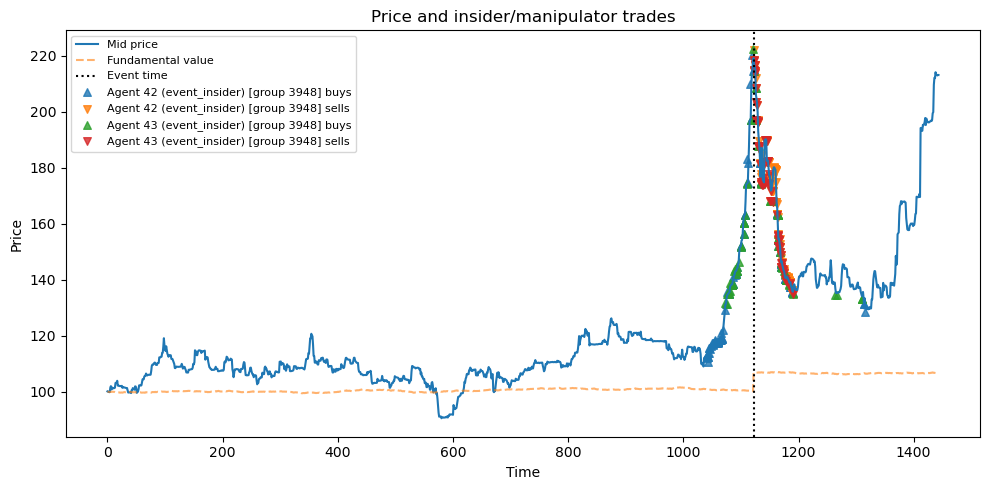

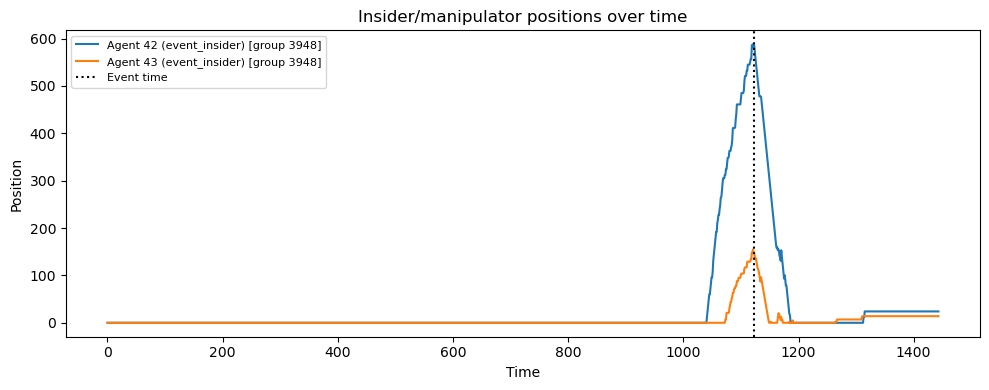

In [19]:
config_example = sample_random_config(run_id=0)
results_example = run_simulation(config_example)

fig1, ax1 = plot_price_with_insider_trades(results_example)
fig2, ax2 = plot_insider_positions(results_example)

## Preparing the agent-level dataset for ML

We now use our simulation machinery to build a dataset for supervised learning:

1. Generate many runs with `generate_dataset`.
2. Keep only the `agent_level` DataFrame.
3. Drop agents that never trade (`n_trades == 0`).
4. Define:
   - Label `y = label_is_illegal` (0 = legal, 1 = illegal).
   - Feature matrix `X` from behavioural numeric columns only.
5. Split by `run_id` into:
   - Training runs.
   - Test runs (completely different scenarios).

This ensures the model is tested on **new markets**, not just new agents in a known market.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [21]:
# Generate a larger dataset for ML (adjust n_runs as needed)
ml_data = generate_dataset(n_runs=250, window_size=50)
agent_df = ml_data["agent_level"].copy()

print("Full agent-level dataset shape:", agent_df.shape)
print("Illegal label distribution:")
print(agent_df["label_is_illegal"].value_counts(normalize=True))

Full agent-level dataset shape: (6968, 18)
Illegal label distribution:
label_is_illegal
False    0.958238
True     0.041762
Name: proportion, dtype: float64


/var/folders/92/b0fqb65132x3sm8hswbm4y9r0000gn/T/ipykernel_42869/2448484529.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agent_level = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()


In [22]:
# Drop agents with no trades (they carry almost no signal)
agent_df = agent_df[agent_df["n_trades"] > 0].reset_index(drop=True)
print("\nAfter dropping agents with zero trades:", agent_df.shape)


After dropping agents with zero trades: (6968, 18)


In [23]:
# Define features and label
label_col = "label_is_illegal"
y = agent_df[label_col].astype(int)

drop_cols = [
    "label_is_illegal",
    "label_illegal_type",
    "type",
    "group_id",
    "agent_id",
    "run_id",
]
feature_cols = [c for c in agent_df.columns if c not in drop_cols]
X = agent_df[feature_cols]

print("Feature columns used:", feature_cols)

Feature columns used: ['cash_final', 'position_final', 'equity_final', 'n_trades', 'total_volume', 'net_volume', 'avg_trade_size', 'buy_volume', 'sell_volume', 'pre_event_volume', 'post_event_volume', 'aligned_pre_event_volume']


In [24]:
# Train/test split by run_id (group-wise split)
unique_runs = agent_df["run_id"].unique()
train_runs, test_runs = train_test_split(
    unique_runs, test_size=0.3, random_state=42
)

train_mask = agent_df["run_id"].isin(train_runs)
test_mask = agent_df["run_id"].isin(test_runs)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train set size: {X_train.shape[0]} agents from {len(train_runs)} runs")
print(f"Test set size:  {X_test.shape[0]} agents from {len(test_runs)} runs")

Train set size: 4922 agents from 175 runs
Test set size:  2046 agents from 75 runs


## Training and evaluating a Random Forest classifier

We now fit a simple model:

- Standardize features with `StandardScaler`.
- Train a `RandomForestClassifier` with:
  - `n_estimators=200`
  - `max_depth=6`
  - `class_weight='balanced'` to compensate for the rarity of illegal agents.

We then evaluate:

- Classification report (precision, recall, F1).
- Confusion matrix.
- ROC AUC (using predicted probabilities).

The goal is not to optimise hyperparameters but to show that **behavioural features carry signal** about who is likely illegal.

In [25]:
# Define and train model
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                random_state=42,
                class_weight="balanced",  # handle class imbalance
            ),
        ),
    ]
)

clf.fit(X_train, y_train)

# Evaluate on test set
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\n=== Agent-level classification report (test set) ===")
print(classification_report(y_test, y_pred, digits=3))


=== Agent-level classification report (test set) ===
              precision    recall  f1-score   support

           0      0.991     0.970     0.980      1954
           1      0.560     0.815     0.664        92

    accuracy                          0.963      2046
   macro avg      0.775     0.893     0.822      2046
weighted avg      0.972     0.963     0.966      2046



In [26]:
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))

try:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC (test): {auc:.3f}")
except ValueError:
    print("ROC AUC could not be computed (only one class present in y_test).")

Confusion matrix (rows=true, cols=pred):
[[1895   59]
 [  17   75]]
ROC AUC (test): 0.980


## Which features does the model rely on?

Random Forests can report **feature importances** based on how much each feature reduces impurity across trees.

We inspect these importances to see:

- Which behavioural patterns the model finds most informative.
- Whether the model is relying mostly on a small subset of features (e.g. `n_trades`) or a broader mix (volume, positions, event-aligned volume, etc.).

In [27]:
rf_model = clf.named_steps["model"]
importances = rf_model.feature_importances_
feat_imp = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
)

print("\nTop 10 most important features:")
print(feat_imp.head(10))


Top 10 most important features:
                     feature  importance
3                   n_trades    0.187871
1             position_final    0.138007
5                 net_volume    0.109833
9           pre_event_volume    0.094590
7                 buy_volume    0.085133
8                sell_volume    0.082706
4               total_volume    0.074645
11  aligned_pre_event_volume    0.069358
0                 cash_final    0.052604
6             avg_trade_size    0.041573


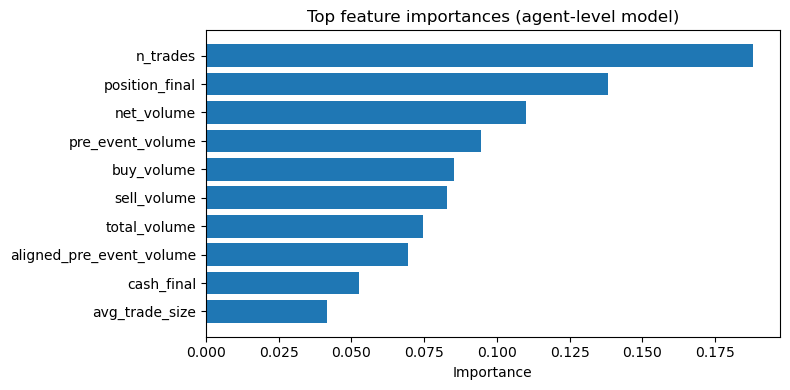

In [28]:
plt.figure(figsize=(8, 4))
top_n = 10
plt.barh(
    feat_imp["feature"].head(top_n)[::-1],
    feat_imp["importance"].head(top_n)[::-1],
)
plt.title("Top feature importances (agent-level model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Interpreting the model: how important is `n_trades`?

The feature importance plot shows `n_trades` as the most important feature.
To understand this, we:

1. Examine the **distribution of `n_trades` by label**:
   - Compute summary statistics separately for legal and illegal agents.
   - Plot a boxplot of `n_trades` vs `label_is_illegal`.

2. Retrain the model **without** `n_trades`:
   - Compare classification report and ROC AUC to the original model.
   - See whether performance drops significantly or only slightly.

This is a great teaching moment:

- A highly important feature might be used mainly as a **“rule-out” signal** (“extremely active looks like a market maker, not an insider”).
- Removing it shows whether the model actually relies on richer behavioural patterns like net volume and event-aligned volume.

In [29]:
# Distribution of n_trades by label
agent_df.groupby("label_is_illegal")["n_trades"].describe()

,count,mean,std,min,25%,50%,75%,max
label_is_illegal,,,,,,,,
False,6677.0,592.373072,790.678042,82.0,281.0,408.0,567.0,7389.0
True,291.0,180.285223,80.601474,39.0,118.5,174.0,227.5,398.0


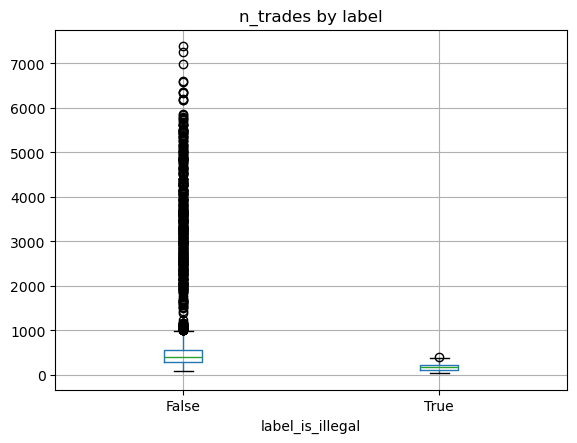

In [30]:
# Visualize
agent_df.boxplot(column="n_trades", by="label_is_illegal")
plt.suptitle("")
plt.title("n_trades by label")
plt.show()

In [31]:
# Retrain without n_trades
X_no_n = agent_df[[c for c in feature_cols if c != "n_trades"]]

X_train_no_n, X_test_no_n = X_no_n[train_mask], X_no_n[test_mask]

clf_no_n = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=6,
            random_state=42,
            class_weight="balanced",
        )),
    ]
)

clf_no_n.fit(X_train_no_n, y_train)
y_pred_no_n = clf_no_n.predict(X_test_no_n)
y_proba_no_n = clf_no_n.predict_proba(X_test_no_n)[:, 1]

print(classification_report(y_test, y_pred_no_n, digits=3))
print("ROC AUC (no n_trades):", roc_auc_score(y_test, y_proba_no_n))


              precision    recall  f1-score   support

           0      0.990     0.965     0.977      1954
           1      0.514     0.783     0.621        92

    accuracy                          0.957      2046
   macro avg      0.752     0.874     0.799      2046
weighted avg      0.968     0.957     0.961      2046

ROC AUC (no n_trades): 0.9782386186640559
